# 0. Setup

In [52]:
# Import packages needed for other analysis

import numpy as np
from numpy.testing import assert_almost_equal
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (20, 15)
plt.style.use('ggplot')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.rc('lines', linewidth=4.0)
import scipy
from scipy.optimize import minimize, brentq, newton

from scipy.stats import norm, jarque_bera
from statsmodels.stats.diagnostic import lilliefors

import warnings
warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [53]:

def covariance_calc(H, k):
    #Calculation derived in dissertation. For two fBM points
    #with a gap k and a given Hurst exponent H, calculate
    #their covariance
    
    return 0.5\
        * (np.abs(k - 1) ** (2 * H)\
         + np.abs(k + 1) ** (2 * H)\
         - 2 * (np.abs(k) ** (2 * H)))

#Test basic functionality. Numbers calculated by hand
assert_almost_equal(covariance_calc(0.5, 1), 0)
assert_almost_equal(covariance_calc(0.25, 1), -0.2928932)
assert_almost_equal(covariance_calc(0.25, -1), -0.2928932)
assert_almost_equal(covariance_calc(0.75, 4), 0.1882461)

def get_covariance_matrix(n_steps, H):
    #Return an unscaled covariance matrix for a FBM with n 
    # steps in it and a given Hurst exponent H
    m = np.zeros([n_steps , n_steps])
    k = np.arange(0, n_steps, 1)

    #Calculate one column, then use this to populate rest 
    # of lower triangle of matrix
    m[:, 0] = covariance_calc(H, k)

    for i in range(1, n_steps):
        m[i:, i] = m[i-1:-1, i-1]
    
    m = np.tril(m) + np.triu(m.T, 1)
    return m

#Test matrix build right. Numbers calculated by hand. 
assert_almost_equal(get_covariance_matrix(3, 0.25), 
                    np.array([[1, -0.2928932, -0.0481881], 
                              [-0.2928932, 1, -0.2928932], 
                              [-0.0481881, -0.2928932, 1]]))


In [54]:
#Data Manipulation

def add_zero(path):
    #This function needed because not all Brownian motion
    #files start with 0, and they should for consistency
    if path[0,] != 0:
        path = np.insert(path, 0, 0)
    return path
    
test1 = np.array([1, 2, 3])
test2 = np.array([0, -1, -2, -3])
assert_almost_equal(np.array([0, 1, 2, 3]), add_zero(test1))
assert_almost_equal(test2, add_zero(test2))

def get_diffs(path):
    # Get the differences of a path i.e. the individual
    # increments
    return path[1:] - path[:-1]

assert_almost_equal(get_diffs(np.array([1, 1, 1, 1, 1])),
                     np.array([0, 0, 0, 0]))
assert_almost_equal(get_diffs(np.array([1, 2, 3, 4, 5])),
                     np.array([1, 1, 1, 1]))

def get_second_order_diffs(path):
    # Get second order differences of a path - needed in
    # chapter 3 for more complicated estimators of H
    return path[2:] - 2 * path[1:-1] + path[:-2]

assert_almost_equal(
    get_second_order_diffs(
        np.array([1, 1, 1, 1, 1])), np.array([0, 0, 0]
        )
    )
assert_almost_equal(
    get_second_order_diffs(
        np.array([1, 2, 3, 4, 5])),np.array([0, 0, 0]
        )
    )

#Get spot variances in spanned sets of a path. Needed in
# chapter 2 when fitting MLE to spot variance rather than
# the 'true' variance 
def estimate_spot_variance(S_path, span):
    #Implicitly assuming we are looking at a range[0, 1]
    #Check can divide range into equal sub-sections Assume
    #path starts with 0 at time 0

    n_steps = S_path.shape[0] - 1
    assert_almost_equal(n_steps % span, 0)
    n_windows = n_steps / span
    delta_t = 1 / n_windows

    log_returns = np.log(S_path[1:]/S_path[:-1])
    spanned_returns = np.split(log_returns, n_windows)

    spot_variances = np.zeros(int(n_windows))

    for i, v in enumerate(spanned_returns):
        spot_variances[i] = np.dot(v, v) 

    return spot_variances

test_path = np.arange(1, 22)
assert_almost_equal(estimate_spot_variance(test_path, 10),
                     np.array([0.8863009, 0.0432722]))



In [55]:
## Black-Scholes

def get_d1_and_d2(S, t, K, T, r, sigma):
    tau = T - t
    d1 = 1/(sigma * np.sqrt(tau)) * (np.log(S/K) + \
                                (r + sigma ** 2 / 2) * tau)    
    d2 = d1 - sigma * np.sqrt(tau)
    return d1, d2

def get_IV_from_price(S, t, K, T, r, market_price):

    def black_scholes_call_price(sigma):
        d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
        call_price = (S * norm.cdf(d1) 
            - K * np.exp(-r * (T- t)) * norm.cdf(d2))
        return call_price - market_price

    return brentq(black_scholes_call_price,\
                   1e-10, 100, maxiter = 500)

assert_almost_equal(
    get_IV_from_price(100, 0, 100, 1, 0, 7.96558 ),
                     0.2, decimal = 5
                     )
assert_almost_equal(
    get_IV_from_price(100, 0, 90, 1, 0, 34.77223 ),
                     0.8, decimal = 5
                     )


In [56]:
def H_estimator(path, T):
    #Return the simple (Gladyshev) estimator of H derived
    #  in dissertation. Assume q = 2. 

    q = 2

    path = add_zero(path)
    diffs = np.absolute(get_diffs(path))
    n_steps = diffs.shape[0]

    return np.log(1/n_steps * np.sum(diffs ** q))  \
        / (q * np.log(T / n_steps))

## 0.2 Simulation

In [57]:
## Simulation

def simulate_bm_fbm(n_sims, n_steps, T, H,
        rng = None, do_both_paths = True):
    #returns B and BH paths; simulating fBM is critcal for
    # the dissertation, but being able to simulate both at
    # once is needed for specific tasks in the RFSV setup.

    if rng is None:
        rng = np.random.default_rng(seed = 1729)
    
    variates = rng.normal(loc = 0, scale = 1,
        size = (n_sims, n_steps))
    B_path = None
    BH_path = np.zeros([n_sims, n_steps + 1])

    delta = (T / n_steps)

    if do_both_paths or H == 0.5:
        B_path = np.zeros([n_sims, n_steps + 1])
        for i in range(0, n_steps):
            B_path[:, i + 1] = B_path[:, i]  \
            + delta ** 0.5 * variates[:, i]

    if H != 0.5:
        print('Beginning Simulation')
        cov_mat = get_covariance_matrix(n_steps, H)
        L = np.linalg.cholesky(cov_mat)
        print('Covariance Done')
        corr_variates = (L @ variates.T).T
    
        for i in range(0, n_steps):
            BH_path[:, i + 1] = BH_path[:, i] \
            + corr_variates[:, i] * delta ** H
    else:
        BH_path = B_path

    return B_path, BH_path


Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done


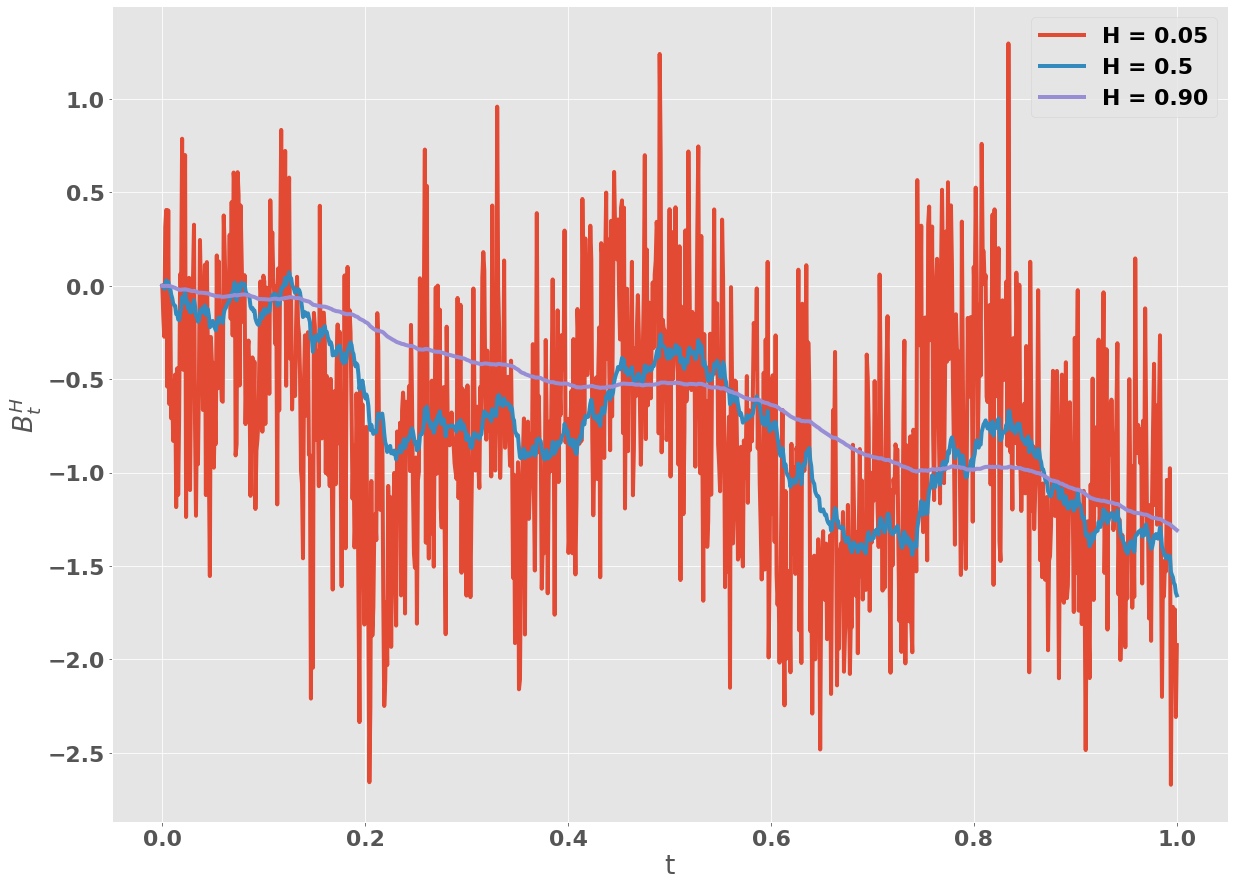

In [58]:
def make_fbm_plots():
    # Uses the simulation function to make some plots of
    # various instances of fBM. 

    n_steps = 1024
    T = 1

    span = np.linspace(0, T, n_steps + 1)

    out = simulate_bm_fbm(1, n_steps, T, 0.05)[1]
    plt.plot(span, out.T, label = "H = 0.05")

    out = simulate_bm_fbm(1, n_steps, T, 0.5)[1]
    plt.plot(span, out.T, label = "H = 0.5")

    out = simulate_bm_fbm(1, n_steps, T, 0.90)[1]
    plt.plot(span, out.T, label = "H = 0.90")
    plt.xlabel("t")
    plt.ylabel("$B^H_t$")
    plt.legend()
make_fbm_plots()

In [59]:
def test_simulation():

    #Test that the simulation engine is working
    #appropriately. We use the simple estimator of the Hurst
    #exponent to check simulated paths report appropriate
    #Hurst exponent values

    n_sims = 500
    n_steps = 1024

    H_vals = np.arange(0.1, 1, 0.1)

    H_est = np.zeros(H_vals.shape)
    H_sd = np.zeros(H_vals.shape)
    tmp_H = np.zeros(n_sims)

    for i, i_val in enumerate(H_vals):
        sims = simulate_bm_fbm(n_sims, n_steps, 1, i_val)[1]
        for j, j_sim in enumerate(sims):
            tmp_H[j] = H_estimator(j_sim, 1)
        H_est[i] = np.mean(tmp_H)
        H_sd[i] = np.std(tmp_H)

    return H_est, H_sd

test_simulation()


Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done


(array([0.10036302, 0.20035275, 0.30034065, 0.400323  , 0.50029162,
        0.60022937, 0.70010852, 0.80000433, 0.90181096]),
 array([0.0036555 , 0.00349106, 0.00334027, 0.00322142, 0.00317598,
        0.00332092, 0.00413182, 0.00783806, 0.02168742]))

# 1. MLE

In [60]:
def obj(H, x):
    #Objective Function for maximising MLE

    n_steps = x.shape[0]
    R = get_covariance_matrix(n_steps, H)

    determinant = np.linalg.slogdet(R)[1]
    R_inv = np.linalg.inv(R)

    return determinant  + n_steps * \
        np.log(1 / n_steps * np.dot(x.T, np.dot(R_inv, x))) 

def max_MLE(x, T, scalar = None):

    #Given a path x over an interval T, obtain MLE H and 
    #scalar. If scalar is known, it can be passed as an
    #input

    #Add x_0 value if it is missing
    if x[0,] != 0:
        x = np.insert(x, 0, 0)
    
    diffs = x[1:] - x[:-1]
    n_steps = diffs.shape[0]
    
    #initial_guess = H_estimator(x, T)
    initial_guess = 0.5

    #Convergence issues noticed around H = 0.95, setting a
    #bound of 0.94 Set lower bound of floating epsilon to
    #stop H hitting exactly 0, which will cause LLF errors
    H = minimize(obj, initial_guess, args = (diffs),
                  bounds = [(np.finfo(float).eps, 0.95)],
                    method = "Powell", tol = 1e-10)

    if H.success:
        H_hat = H.x[0]
        R = get_covariance_matrix(n_steps, H_hat)
        if scalar is None:
            scalar = (T / n_steps) ** (2 * H_hat)
            R_inv = np.linalg.inv(R)
            sigma_hat = np.sqrt(1 / (n_steps * scalar) \
                * np.dot(diffs.T, np.dot(R_inv, diffs)))
        else:
            sigma_hat = scalar
        return H_hat, sigma_hat

    return H.success

In [61]:
def test_MLE(scalar = 1):

    # Test that MLE works properly by simulating various
    # cases and checking that the estimates are close to
    # the true values.

    n_sims = 100
    n_steps = 100

    H_vals = np.arange(0.25, 1, 0.25)

    H_est = np.zeros(H_vals.shape)
    H_sd = np.zeros(H_vals.shape)
    scalar_est = np.zeros(H_vals.shape)
    scalar_sd = np.zeros(H_vals.shape)
    tmp_H = np.zeros(n_sims)
    tmp_scalar = np.zeros(n_sims)

    for i, i_val in enumerate(H_vals):
        sims = simulate_bm_fbm(
            n_sims, n_steps, 1, i_val)[1] * scalar
        for j, j_sim in enumerate(sims):
            out = max_MLE(j_sim, 1)
            tmp_H[j] = out[0]
            tmp_scalar[j] = out[1]
        H_est[i] = np.mean(tmp_H)
        H_sd[i] = np.std(tmp_H)
        scalar_est[i] = np.mean(tmp_scalar)
        scalar_sd[i] = np.std(tmp_H)

    return H_est, H_sd, scalar_est, scalar_sd

test_MLE(1)

Beginning Simulation
Covariance Done
Beginning Simulation
Covariance Done


(array([0.24812697, 0.49651077, 0.74484134]),
 array([0.05405318, 0.06422749, 0.06418681]),
 array([1.00500824, 1.01713246, 1.03857159]),
 array([0.05405318, 0.06422749, 0.06418681]))

Beginning Simulation
Covariance Done
-0.8371093986083677 0.6045443586353594
0.7811068024630937 0.7909821547861726
-3.1095816630915993 -1.802834383774
1.6892493010513971 3.038877323643


(0.03567542854526159, 1.1596978669856177)

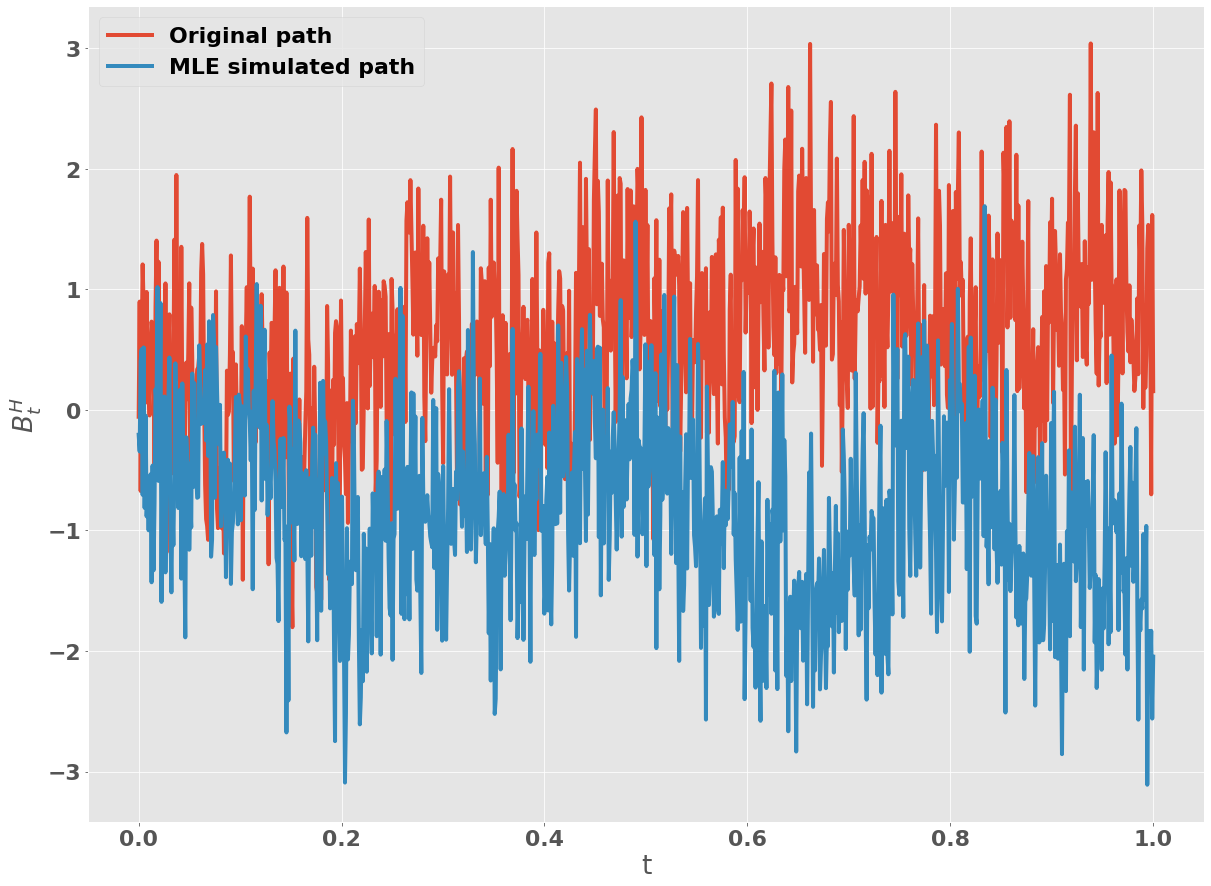

In [64]:
def test_path():

    sample_fbm = np.loadtxt(
    'C:\\Users\\jamma\Masters\\Dissertation\\fBMPath2.txt'
    )
    res = max_MLE(sample_fbm, 1)

    comparison = res[1] * \
        simulate_bm_fbm(1, 1024, 1, res[0])[1]

    plt.plot(np.linspace(0, 1, 1024),
        sample_fbm, label = 'Original path')
    plt.plot(np.linspace(0, 1, 1024), 
        comparison[0, 1:], label = 'MLE simulated path')
    plt.xlabel("t")
    plt.ylabel("$B_t^H$")
    plt.legend()

    print(np.mean(comparison[0, 1:]), np.mean(sample_fbm))
    print(np.std(comparison[0, 1:]),  np.std(sample_fbm))
    print(np.min(comparison[0, 1:]),  np.min(sample_fbm))
    print(np.max(comparison[0, 1:]),  np.max(sample_fbm))

    return (res)

test_path()

# 2. Simulation

### 2.1 With given Paths

In [89]:
class RFSV_model:
    #A class to do RFSV simulations. Loads in various
    #parameters and estimates H based on realised volatility
    #with a known spanning length
    def __init__(self, V0, S0, V, rho, H, T,
            B_path, BH_path, W_path, window_length):
        #inputs
        self.V0 = V0
        self.S0 = S0
        self.V = V
        self.rho = rho
        self.rho_bar = np.sqrt(1 - rho ** 2)
        self.window_length = window_length
        self.H = H
        self.T = T

        #Derived
        self.B_path = B_path
        self.BH_path = BH_path
        self.W_path = W_path
        
        self.n_steps = self.B_path.shape[0] - 1
        self.delta = self.T * \
            self.window_length / self.n_steps


    def run_H_estimation(self):
        self.simulate_RFSV()
        self.variance_estimation()
        return self.est_H, self.MLE_H
    
    def simulate_RFSV(self):
        
        B_diffs = get_diffs(self.B_path)
        W_diffs = get_diffs(self.W_path)

        S_path = np.zeros(self.n_steps + 1)
        V_path = np.zeros(self.n_steps + 1)

        V_path = self.V0 * np.exp(self.V * self.BH_path)
        S_path[0] = self.S0
        
        for i in range(self.n_steps):
            S_path[i + 1] = S_path[i] *\
                (
                1 + np.sqrt(V_path[i]) *\
                (self.rho * B_diffs[i] + \
                  self.rho_bar * W_diffs[i]
                  )
                  )
        
        self.V_path = V_path
        self.S_path = S_path

    def variance_estimation(self):
        est_V = estimate_spot_variance(self.S_path,
            self.window_length)

        self.est_H = H_estimator(np.log(self.V_path / self.V0), 1)

        self.MLE_H = max_MLE(
            add_zero(est_V/self.V0), 1, scalar = self.V
            )[0]

In [90]:
#H = 0.05 RFSV model

B_path_loc_05 = \
    'C:\\Users\\jamma\\Masters\\Dissertation\\Bpath.05.txt'
BH_path_loc_05 = \
    'C:\\Users\\jamma\\Masters\\Dissertation\\BHpath.05.txt'
W_path_loc_05 = \
    'C:\\Users\\jamma\\Masters\\Dissertation\\Wpath.05.txt'

B_path_05 = add_zero(np.loadtxt(B_path_loc_05))
BH_path_05 = add_zero(np.loadtxt(BH_path_loc_05))
W_path_05 = add_zero(np.loadtxt(W_path_loc_05))

window_lengths = [16, 32, 64]

for window_length in window_lengths:
    test = RFSV_model(0.1, 1, 1, -0.65, 0.05, 1,
        B_path_05, BH_path_05, W_path_05, window_length)

    est_H, MLE_H = test.run_H_estimation()
    print(est_H, MLE_H)


0.05058175194263949 0.03172093750685798
0.05058175194263949 0.060494733760738585
0.05058175194263949 0.13620490604424584


In [91]:
#H = 0.10 model

B_path_loc_10 = \
'C:\\Users\\jamma\\Masters\\Dissertation\\Bpath.10.txt'
BH_path_loc_10 = \
'C:\\Users\\jamma\\Masters\\Dissertation\\BHpath.10.txt'
W_path_loc_10 = \
'C:\\Users\\jamma\\Masters\\Dissertation\\Wpath.10.txt'

B_path_10 = add_zero(np.loadtxt(B_path_loc_10))
BH_path_10 = add_zero(np.loadtxt(BH_path_loc_10))
W_path_10 = add_zero(np.loadtxt(W_path_loc_10))

window_lengths = [16, 32, 64]

for window in window_lengths:
    test = RFSV_model(0.1, 1, 1, -0.65, 0.1, 1, \
        B_path_10, BH_path_10, W_path_10, window)

    est_H, MLE_H = test.run_H_estimation()
    print(est_H, MLE_H)


0.10233969211163327 0.06672126070200399
0.10233969211163327 0.1201595932499518
0.10233969211163327 0.15462335568051722


### 2.2 H = 0.5, 100 paths

In [92]:
def run_half_H_case():
    # Run 100 simulations of the RFSV with H = 0.5
    n_sims = 100
    n_steps = 2 ** 16

    sim_est_H = np.zeros(n_sims)
    sim_MLE_H = np.zeros(n_sims)

    S0 = 1
    v = 1
    rho = -0.65
    V0 = 0.1
    window_length = 512

    rng = np.random.default_rng(seed = 1729)
    B_paths = \
        simulate_bm_fbm(n_sims, n_steps, 1, 0.5, rng)[0]
    rng = np.random.default_rng(seed = 42)
    W_paths = \
        simulate_bm_fbm(n_sims, n_steps, 1, 0.5, rng)[0]

    for i in range(n_sims):
        if (i + 1) % 5 == 0:
            print(f"{(i + 1) / 100:.0%}")
        model = RFSV_model(V0, S0, v, rho, 0.5, 1, \
            B_paths[i, :], B_paths[i, :], W_paths[i, :],\
            window_length)
        est_H, MLE_H = model.run_H_estimation()

        sim_est_H[i] = est_H
        sim_MLE_H[i] = MLE_H

    plt.hist(sim_MLE_H)

    return sim_est_H, sim_MLE_H

5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
55%
60%
65%
70%
75%
80%
85%
90%
95%
100%


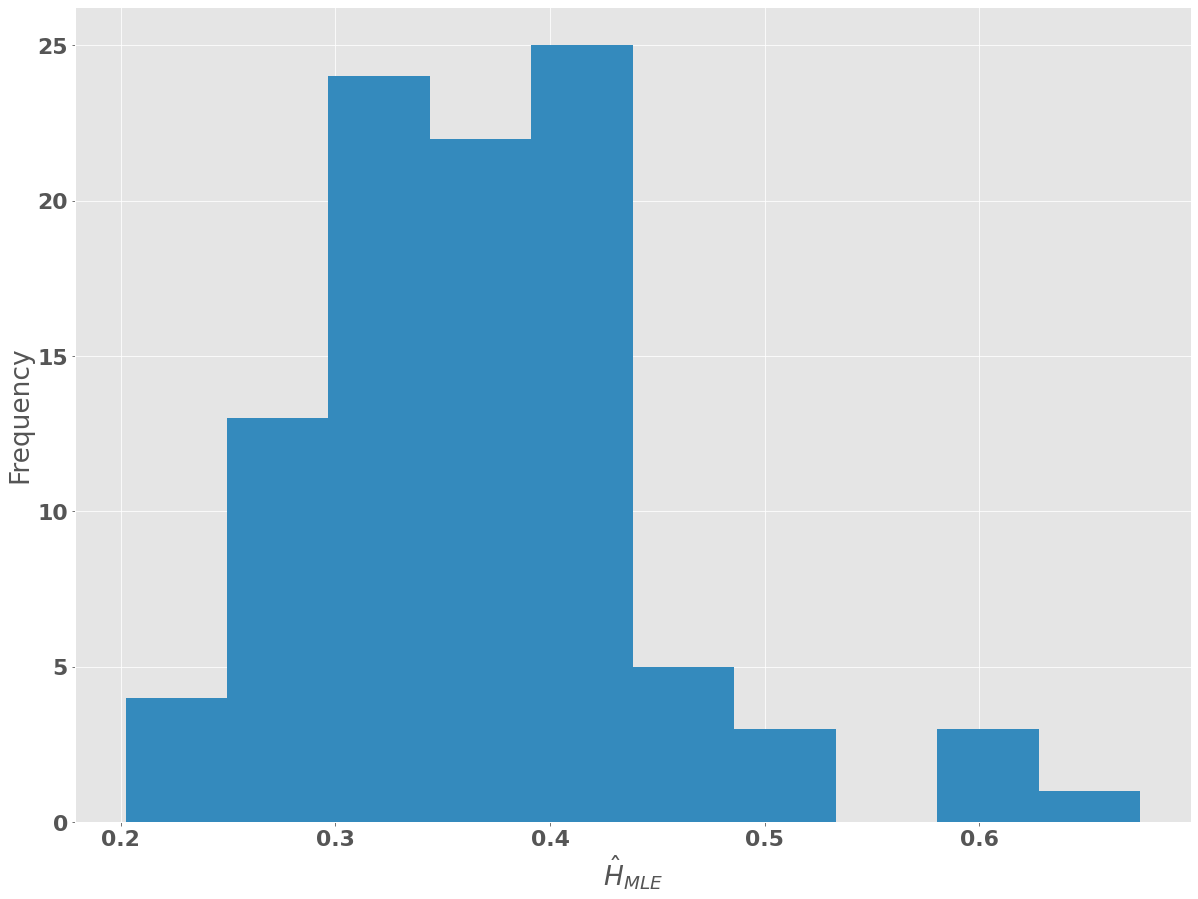

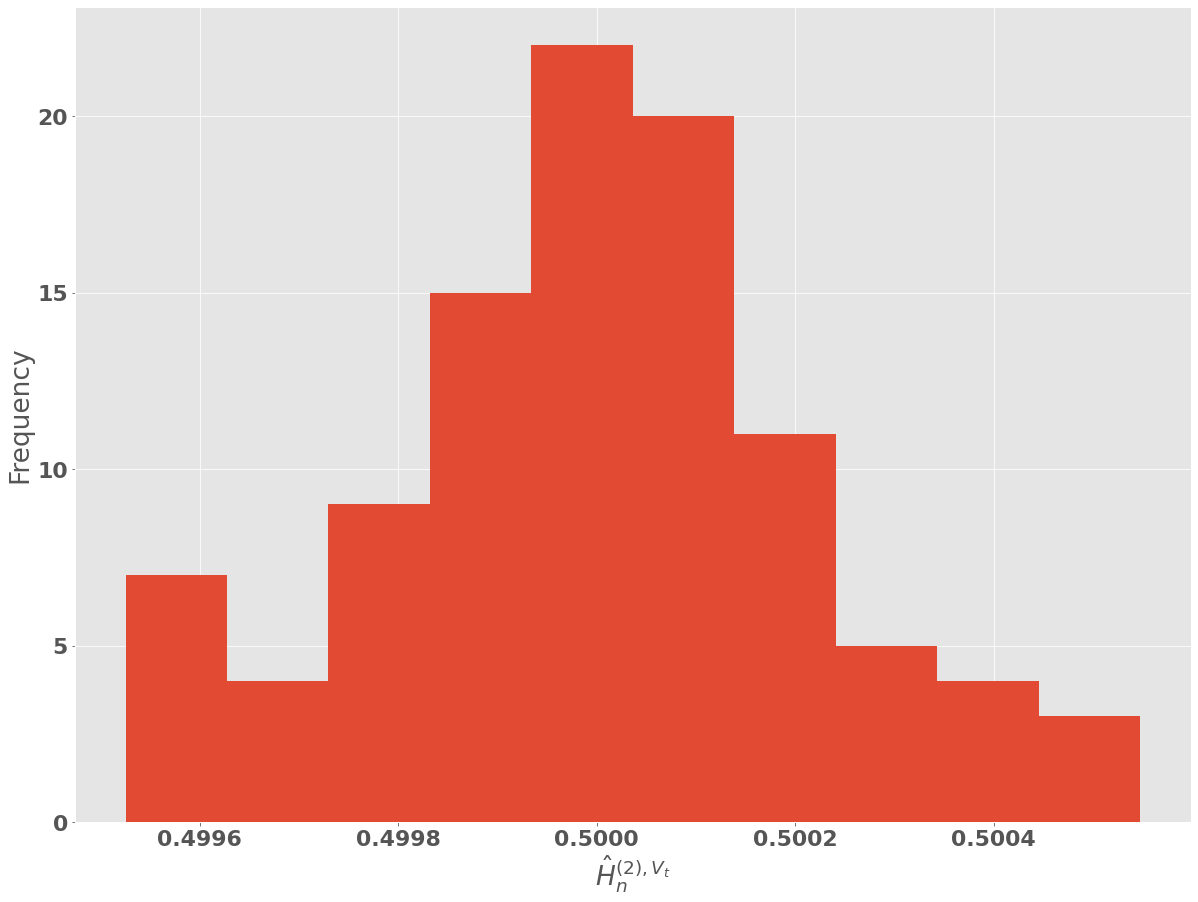

0.3694478885273598
0.08402256249320712
-0.13055211147264018
0.20476669215190785
0.5341290849028117
0.5000032587630908
0.00021983072330728813
3.2587630908187393e-06
0.4995723984627131
0.5004341190634685


In [96]:
def half_H_analytics():
      #Analytics based on the 100 simulations of RFSV with H = 0.5
      sim_est_H, sim_MLE_H = run_half_H_case()
      plt.hist(sim_MLE_H)
      plt.xlabel("$\hat{H}_{MLE}$")
      plt.ylabel("Frequency")
      plt.show()

      plt.hist(sim_est_H)
      plt.xlabel("$\hat{H}^{(2),V_t}_n$")
      plt.ylabel("Frequency")
      plt.show()

      print(np.mean(sim_MLE_H))
      print(np.std(sim_MLE_H))
      print(np.mean(sim_MLE_H) - 0.5)

      print(np.mean(sim_MLE_H) + 
            np.std(sim_MLE_H)* norm.ppf(0.025))
      print(np.mean(sim_MLE_H) + 
            np.std(sim_MLE_H)* norm.ppf(0.975))

      print(np.mean(sim_est_H))
      print(np.std(sim_est_H))
      print(np.mean(sim_est_H) - 0.5)

      print(np.mean(sim_est_H) + 
            np.std(sim_est_H)* norm.ppf(0.025))
      print(np.mean(sim_est_H) + 
            np.std(sim_est_H)* norm.ppf(0.975))

half_H_analytics()

### 2.3 Monte Carlo Pricing

Beginning Simulation
Covariance Done
Simulation done
5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
55%
60%
65%
70%
75%
80%
85%
90%
95%
100%


array([0.31015423, 0.29395724, 0.27710551, 0.26019342, 0.24275313,
       0.22600798, 0.21200006, 0.20273199, 0.19981258, 0.20105933,
       0.20483614])

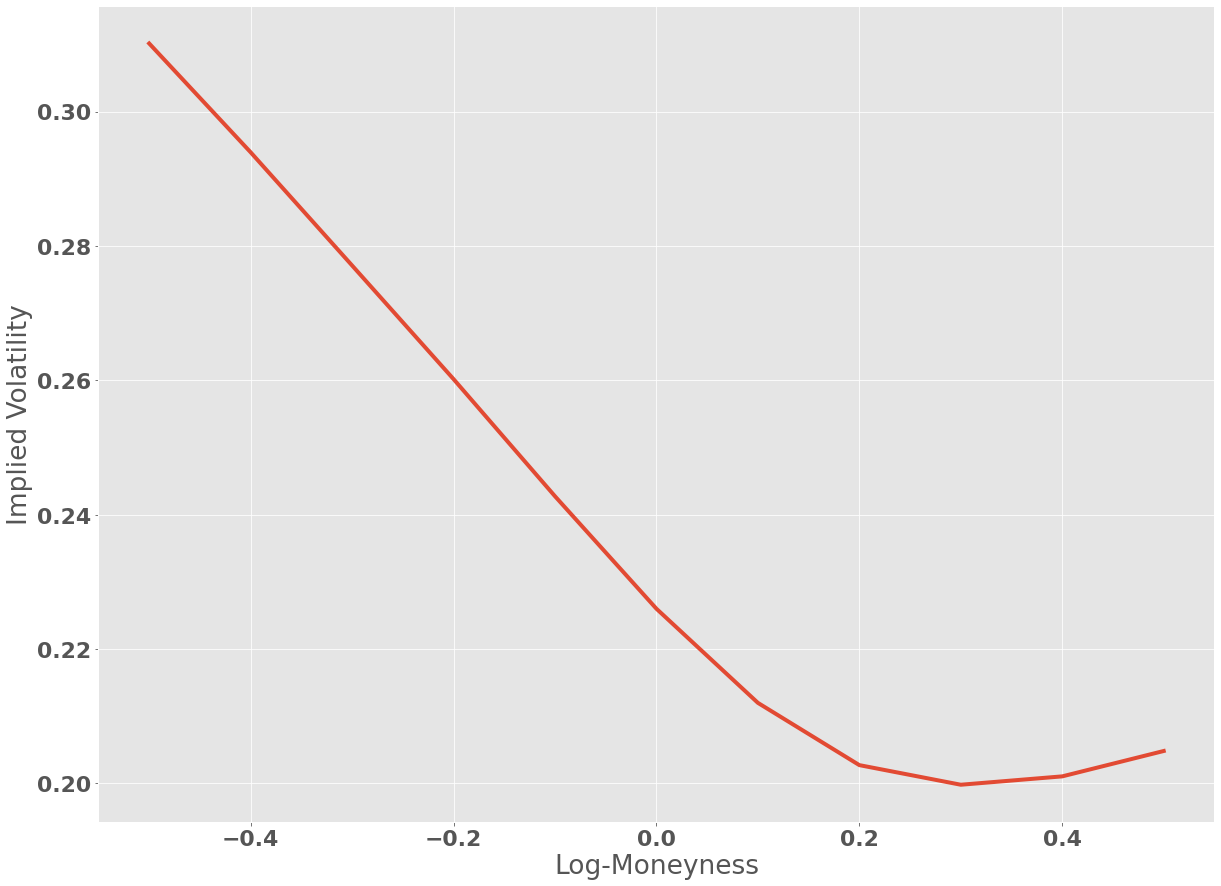

In [106]:
def MC_Pricing_RFSV():
    #Pricing Options with RFSV, this returns implied
    #volatilities based on simulations 

    n_sims = 10000
    n_steps = 2 ** 14 #consistent with simulated sample paths

    S0 = 1
    v = 1
    rho = -0.65
    V0 = 0.04
    H = 0.1
    dummy_window_length = 512

    log_moneyness = np.arange(-0.5, 0.6, 0.1)
    call_prices = np.zeros(log_moneyness.shape)
    IVs = np.zeros(log_moneyness.shape)

    rng = np.random.default_rng(seed = 1729)
    B_sim, BH_sim = simulate_bm_fbm(int(n_sims / 2),
                                     n_steps, 1, H, rng)
    rng = np.random.default_rng(seed = 42)
    W_sim = simulate_bm_fbm(int(n_sims / 2),
                             n_steps, 1, 0.5, rng)[0]
    print('Simulation done')

    B_paths = np.vstack((B_sim, -B_sim))
    BH_paths = np.vstack((BH_sim, -BH_sim))
    W_paths = np.vstack((W_sim, -W_sim))
    S1_paths = np.zeros([n_sims, 1])

    for i in range  (n_sims):
        if (i + 1) % 500 == 0:
            print(f"{(i + 1) / n_sims:.0%}")
        model = RFSV_model(V0, v, S0, rho, 0.1, 1,
            B_paths[i, :], BH_paths[i, :],
            W_paths[i, :], dummy_window_length)
        model.simulate_RFSV()
        S1_paths[i] = model.S_path[-1]

    for i, v in enumerate(log_moneyness):
        strike = S0 * np.exp(v)
        call_prices[i] = np.average(
            np.maximum(S1_paths - strike, 0))
        IVs[i] = get_IV_from_price(
            S0, 0, strike, 1, 0, call_prices[i])

    plt.plot(log_moneyness, IVs)
    plt.xlabel("Log-Moneyness")
    plt.ylabel("Implied Volatility")
    return IVs

MC_Pricing_RFSV()

# 3. Further Estimation

NameError: name 'max_MLE' is not defined

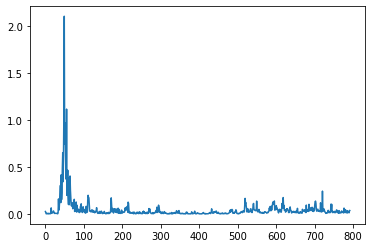

In [ ]:
def make_SPX_graphs(SPX_data, V0_input = None,
        make_graphs = True):

    #Plots SPX charts and fits MLE to the input SPX data.
    #This code answers a specific prompt in the dissertation
    #to look at all three years and the last year of data

    if V0_input is None:
        V0_input = np.exp(np.mean(np.log(SPX_data)))

    SPX_adjusted = add_zero(np.log(SPX_data / V0_input ))
    
    H_hat_SPX, sigma_hat_SPX = max_MLE(SPX_adjusted,
        SPX_adjusted.shape[0])
    span = np.linspace(0, SPX_adjusted.shape[0],
        SPX_adjusted.shape[0])
    out = simulate_bm_fbm(1, SPX_adjusted.shape[0] - 1,
        SPX_adjusted.shape[0] - 1, H_hat_SPX)[1]
    
    if make_graphs:
        plt.figure(0)
        plt.plot(SPX_adjusted)
        plt.show()

        plt.figure(1)
        plt.subplot(211)
        plt.plot(span, SPX_adjusted)
        plt.subplot(212)
        plt.plot(span, out.T * sigma_hat_SPX)
        plt.show()

    return H_hat_SPX, sigma_hat_SPX, V0_input

SPX_path = "C:\\Users\\jamma\\Masters\\" \
"Dissertation\\SPX3yrDailyRealizedVariance1minBins.txt"

SPX_data = np.loadtxt(SPX_path)
plt.plot(SPX_data)

V0_given = 0.1
make_SPX_graphs(SPX_data, V0_given)
make_SPX_graphs(SPX_data[-251:], V0_given)

In [ ]:
def make_rolling_H_chart(SPX_path):
    #Calculates estimates of H that depend on how much data
    #was used
    rolling_H = np.zeros(40)
    span = np.zeros(40)

    for i in range(40):
        rolling_H[i] = make_SPX_graphs(SPX_path[19 * i:], V0_given, make_graphs = False)[0]
        span[i] = len(SPX_path) - 19 * i

    plt.plot(span, rolling_H)

make_rolling_H_chart(SPX_data)

NameError: name 'max_MLE' is not defined

# 4 Own investigation

### 4.0 Setup

In [ ]:
class estimator_master():
    #A master estimator class for calculating the tests 
    #proposed in chapter 3 of dissertation
    def __init__(self,
        n_sims = 5_000,
        n_steps = 2 ** 14,
        H_values = np.array([0.5]),
        do_convergence_tests = True,
        T = 1
        ):

        self.H_values = H_values
        self.H_simulated = np.zeros((
            n_sims, H_values.shape[0])
            )

        self.norm_checks_JB = np.zeros(H_values.shape)
        self.norm_checks_LF = np.zeros(H_values.shape)

        # Distribution Check
        self.n_sims = n_sims
        self.n_steps = n_steps
        self.T = T

        self.do_convergence_tests = do_convergence_tests

    def do_analysis(self):
        self.run_simulation()
        if self.do_convergence_tests:
            self.convergence_testing()
        self.do_analytics()

    def H_estimator(self):
        pass

    def run_simulation(self):

        fig, axs = plt.subplots(int(np.ceil(
            self.H_values.shape[0] / 4)), 4,
            figsize=(40, 20))
        
        
        for j, H in enumerate(self.H_values):
            print(H)
            out = simulate_bm_fbm(self.n_sims, self.n_steps,
                self.T, H, do_both_paths = False)[1]
            
            for i in range(out.shape[0]):
                if i % 1_000 == 0:
                    print(i)
                self.H_simulated[i, j] = \
                    self.H_estimator(out[i, :])

            self.norm_checks_JB[j] = \
                jarque_bera(self.H_simulated[:, j]).pvalue
            self.norm_checks_LF[j] = \
                lilliefors(self.H_simulated[:, j])[1]
        
            axs[int(np.floor(j / 4)), j % 4].hist(
                self.H_simulated[:, j], bins = 40, 
                facecolor='blue', alpha=0.5)
            
            y = np.linspace(self.H_simulated[:, j].min(),
                self.H_simulated[:, j].max(), 1000)
            bin_width = (self.H_simulated[:, j].max()
                - self.H_simulated[:, j].min()) / 40
            axs[int(np.floor(j / 4)), j % 4].plot(y, 
                norm.pdf(y, loc = np.mean(
                    self.H_simulated[:, j]),
                    scale = np.std(self.H_simulated[:, j])) 
                    * self.n_sims * bin_width)
        
        fig.show()

        
    def convergence_testing(self):

        exponents = np.arange(3, 13, 1)
        self.H_by_density = np.zeros((len(self.H_values),
            len(exponents)))
        n_sims = 5_000

        fig, axs = plt.subplots(
            int(np.ceil(self.H_values.shape[0] / 4)),
            4, figsize=(40, 20))

        for i, H in enumerate(self.H_values):
            print(H)
            out = simulate_bm_fbm(n_sims,
                int(2 ** (exponents[-1])), 1,
                self.H_values[i], do_both_paths = False)[1]

            for j in range(len(exponents)):
                width = 2 ** (exponents[-1] - exponents[j])
                tmp_out = out[:, 0::width]
                tmp_estimators = np.zeros(n_sims)
            
                for k in range(out.shape[0]):
                    tmp_estimators[k] = \
                    self.H_estimator(tmp_out[k, :])
                
                self.H_by_density[i, j] = np.mean(tmp_estimators)
            
            axs[int(np.floor(i / 4)), i % 4].plot(
                exponents, np.log2(self.H_by_density[i, :]))
            axs[int(np.floor(i / 4)), i % 4].plot(
                exponents, np.tile(np.log2(H), 
                len(exponents)))
            
        fig.show()
        
    def do_analytics(self):
        mean_H = np.zeros(self.H_values.shape)
        sd_H = np.zeros(self.H_values.shape)
        for j, H in enumerate(self.H_values):
            mean_H[j] = np.mean(self.H_simulated[:, j])
            sd_H[j] = np.std(self.H_simulated[:, j])
        self.df_analytics = pd.DataFrame(
            np.column_stack(
                (mean_H, sd_H, self.norm_checks_JB)), 
                index = self.H_values,
                columns = ["Mean", "Standard Deviation",
                "JB p-value"])


### 4.1 Gladyshev

In [ ]:
class gladyshev_estimator(estimator_master):
    def H_estimator(self, x):

        #return estimator of H from dissertation. 
        # Assume q = 2. 
        q = 2

        if x[0,] != 0:
            x = np.insert(x, 0, 0)
        diffs = get_diffs(x)
        n_steps = diffs.shape[0]

        return np.log(1/n_steps * np.sum(diffs ** q)) \
        (q * np.log(self.T / n_steps))
    
glady = gladyshev_estimator(
    H_values = np.array(
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
    n_sims = 5_000,
    n_steps = 2 ** 14,
)

glady.do_analysis()
glady.df_analytics
print(glady.norm_checks_JB)

### 4.2 Istas

In [ ]:
class istas(estimator_master):
    def H_estimator(self, x):

        n_steps = x.shape[0]
        x = add_zero(x)

        full_path_second_order = \
            np.sum(get_second_order_diffs(x) ** 2)
        half_path_second_order = \
            np.sum(get_second_order_diffs(x[::2]) ** 2)


        return 0.5 - 1 / ( 2 * np.log(2)) \
            * np.log(full_path_second_order / 
                half_path_second_order)
    
ist1 = istas(
    H_values = np.array([
        0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
    n_sims = 5_000,
    n_steps = 2 ** 14,
)

ist1.do_analysis()
ist1.df_analytics
print(ist1.norm_checks_JB)

### 4.3 Coeurjolly 2

In [ ]:
class coeurjolly2(estimator_master):
    def H_estimator(self, x):

        n_steps = x.shape[0]
        def coeur_function(y):
            return (self.T / n_steps) ** \
                (2 * y) * (4 - 2 ** (2 * y))

        x = add_zero(x)
        self.path_diffs = 1 / n_steps * \
            np.sum(get_second_order_diffs(x) ** 2)

        def obj_coeur(z):
            return coeur_function(z) - self.path_diffs
        
        return brentq(obj_coeur, -1, 1, maxiter = 500)

coeur2 = coeurjolly2(
    H_values = np.array(
        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        ),
    n_sims = 5_000,
    n_steps = 2 ** 14,
)

coeur2.do_analysis()
print(coeur2.norm_checks_JB)
coeur2.df_analytics

### 4.4 Exact CI

In [ ]:
### Helper Functions

### Source: J.-C. Breton et al./
# Exact intervals for the Hurst parameter
# Code written personally 


def g_inv(n_steps, target):  

    def g(x):
        return x - (np.log(4 - 4 ** x))/ \
            (2 * np.log(n_steps))

    def g_obj(x):
        return g(x) - target  
    
    return brentq(g_obj, 0, 1, maxiter = 500)

def exp_fn(a, n):
    return np.exp(-a ** 2 / (71 * (a/np.sqrt(n) + 3)))

def prob_function(a, n):
    return max(1 - 2 * exp_fn(a, n), 0)

def derive_CI(fbm_file_path, error_range, a):
    fbm_path = np.loadtxt(fbm_file_path) 
    H_star = 0.5

    n_steps = fbm_path.shape[0] - 1

    assert(exp_fn(a, n_steps)) <= error_range / 2
    assert(a < (4 - 4 ** H_star) * np.sqrt(n_steps))

    quad_variations = np.sum(
        get_second_order_diffs(fbm_path) ** 2)

    lower = 0.5 \
    - np.log(quad_variations) / (2 * np.log(n_steps)) \
    + np.log(1 - a / ((4 - 4 ** H_star) 
    * np.sqrt(n_steps)))/(2 * np.log(n_steps))
    upper = 0.5 \
    - np.log(quad_variations) / (2 * np.log(n_steps)) \
    + np.log(1 + a / ((4 - 4 ** H_star) 
    * np.sqrt(n_steps)))/(2*np.log(n_steps))

    lower = max(lower, - np.log(3)/(2 * np.log(n_steps))) 

    return g_inv(n_steps, lower), \
    g_inv(n_steps, upper), \
    prob_function(a, n_steps)

#Use provided sample path to check the CI 
derive_CI('C:\\Users\\jamma\Masters\\Dissertation\\fBMPath2.txt', 0.05, 33) 

NameError: name 'get_second_order_diffs' is not defined